In [1]:
import math
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime
from collections import defaultdict

df1 = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 = pd.read_csv('D://Documenti//Università//Informatica Umanistica//DMII//occupancy_data//datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

Unisco i due dataset

In [2]:
df = pd.concat([df1,df2], ignore_index = True)

Preparazione dataset

In [3]:
dates = pd.to_datetime(df['date'], infer_datetime_format=True)
df['day'] = dates.dt.day
df['absH'] = dates.dt.hour

In [4]:
del df['HumidityRatio']
del df['date']

In [5]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,day,absH,Occupancy
0,23.18,27.2720,426.0,721.25,4,17,1
1,23.15,27.2675,429.5,714.00,4,17,1
2,23.15,27.2450,426.0,713.50,4,17,1
3,23.15,27.2000,426.0,708.25,4,17,1
4,23.10,27.2000,426.0,704.50,4,17,1


# Creazione dataset sbilanciato 96-4%

Distribuzione dataset iniziale

In [7]:
df.shape

(17895, 7)

In [8]:
df[class_name].value_counts()

0    14117
1     3778
Name: Occupancy, dtype: int64

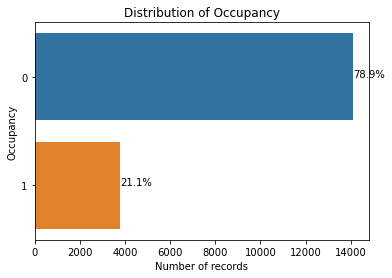

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
ax = sns.countplot(y="Occupancy", data=df)
plt.title('Distribution of Occupancy')
plt.xlabel('Number of records')
total = len(df['Occupancy'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

Primo tentativo (numeri usati da Marco)

In [10]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 3778 - 850, replace=False)

In [11]:
len(df), len(rows2remove)

(17895, 2928)

In [12]:
dfI = df.drop(index=rows2remove, axis=0)
print(len(dfI))

14967


In [13]:
dfI[class_name].value_counts()

0    14117
1      850
Name: Occupancy, dtype: int64

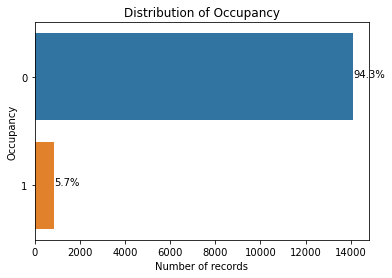

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

attributes = [col for col in dfI.columns if col != class_name]
X = dfI[attributes].values
y = dfI[class_name]
ax = sns.countplot(y="Occupancy", data=dfI)
plt.title('Distribution of Occupancy')
plt.xlabel('Number of records')
total = len(dfI['Occupancy'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

Secondo tentativo

In [15]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 3778 - 588, replace=False)

In [16]:
len(df), len(rows2remove)

(17895, 3190)

In [17]:
dfI = df.drop(index=rows2remove, axis=0)
print(len(dfI))

14705


In [18]:
dfI[class_name].value_counts()

0    14117
1      588
Name: Occupancy, dtype: int64

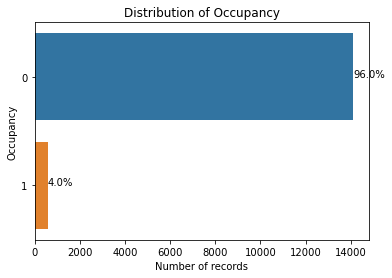

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

attributes = [col for col in dfI.columns if col != class_name]
X = dfI[attributes].values
y = dfI[class_name]
ax = sns.countplot(y="Occupancy", data=dfI)
plt.title('Distribution of Occupancy')
plt.xlabel('Number of records')
total = len(dfI['Occupancy'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

# Splitting

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [21]:
attributes = [col for col in dfI.columns if col != class_name]
X = dfI[attributes].values
y = dfI[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [23]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=500, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9601087941976428
F1-score [0.97964847 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       176

    accuracy                           0.96      4412
   macro avg       0.48      0.50      0.49      4412
weighted avg       0.92      0.96      0.94      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


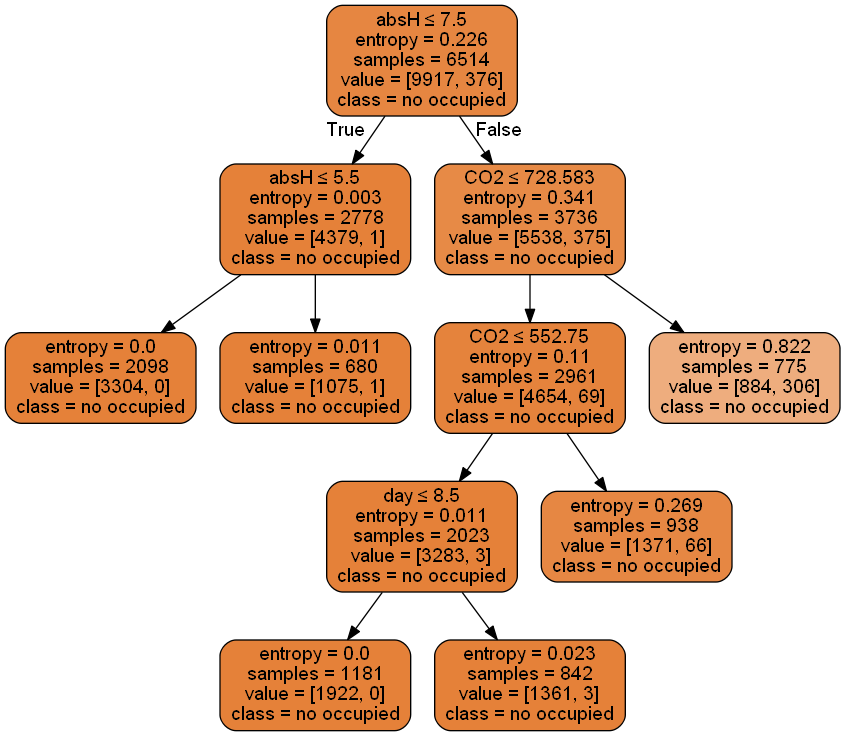

In [24]:
import pydotplus
from sklearn import tree
from IPython.display import Image

dot_data = tree.export_graphviz(clf.estimators_[58], out_file=None,  
                                feature_names=feature_names, 
                                class_names=['no occupied', 'occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [25]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

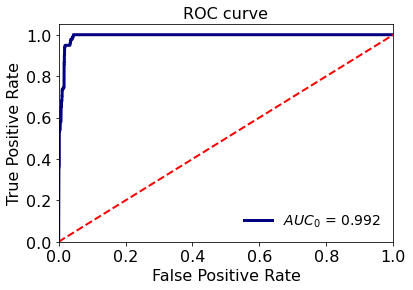

In [26]:
plt.plot(fpr0, tpr0, color='navy', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

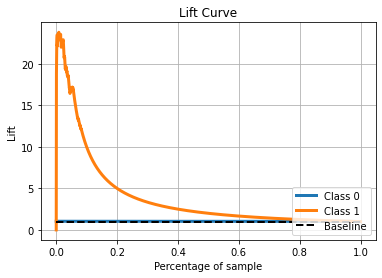

In [27]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_lift_curve
plot_lift_curve(y_test, y_score)
plt.show()

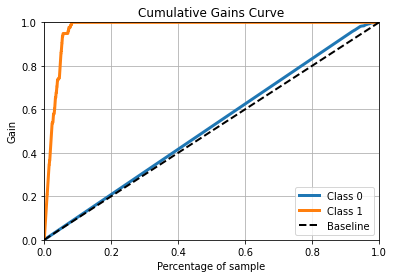

In [28]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, y_score)
plt.show()

Il risultato non è ovviamente soddisfacente, in quanto non vengono riconosciuti i valori della classe minoritaria.

### Adjust the Decision Threshold

In [29]:
y_pred = clf.predict_proba(X_test)
print (y_pred)

### A sinistra la probabilità che sia 0, a destra quella che sia uno

[[9.99922992e-01 7.70079283e-05]
 [9.98320326e-01 1.67967444e-03]
 [9.61224451e-01 3.87755488e-02]
 ...
 [9.98886753e-01 1.11324712e-03]
 [9.86628559e-01 1.33714411e-02]
 [8.72269172e-01 1.27730828e-01]]


In [30]:
y_pred = clf.predict_proba(X_test)[:,1]
print (y_pred)

### Questa è la probabilità che sia 1, ovvero la classe minoritaria

[7.70079283e-05 1.67967444e-03 3.87755488e-02 ... 1.11324712e-03
 1.33714411e-02 1.27730828e-01]


Accuracy 0.9796010879419764
F1-score [0.989301  0.7815534]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4236
           1       0.68      0.91      0.78       176

    accuracy                           0.98      4412
   macro avg       0.84      0.95      0.89      4412
weighted avg       0.98      0.98      0.98      4412



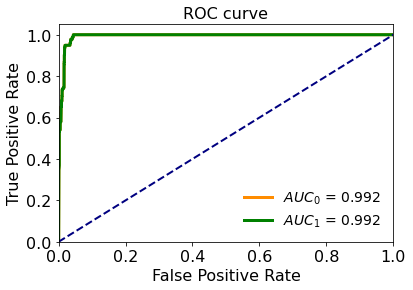

In [31]:
def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

###Osservardo la probabilità di 1, gli dico che se è superiore a 0.3 allora al record deve essere assegnare il valore 1.

Osserviamo che il valore generale di accuracy sale. Sale notevolmente il valore di precision e recall per il valore 1.

### Undersampling: Random undersampling

In [32]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from collections import defaultdict

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 412, 1: 412})


Accuracy 0.9601087941976428
F1-score [0.97964847 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       176

    accuracy                           0.96      4412
   macro avg       0.48      0.50      0.49      4412
weighted avg       0.92      0.96      0.94      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


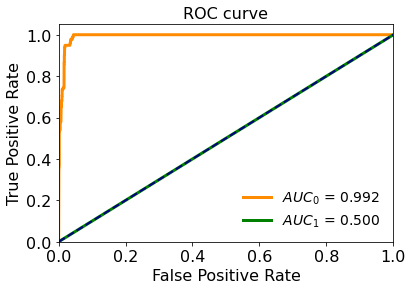

In [33]:
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Undersampling: CondensedNearestNeighbour

In [34]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 412, 0: 74})


Accuracy 0.03989120580235721
F1-score [0.         0.07672188]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4236
           1       0.04      1.00      0.08       176

    accuracy                           0.04      4412
   macro avg       0.02      0.50      0.04      4412
weighted avg       0.00      0.04      0.00      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


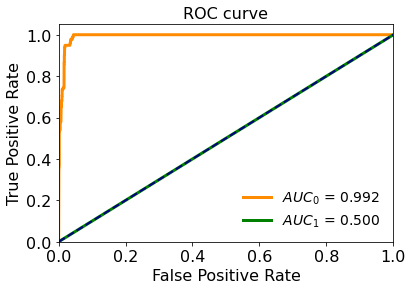

In [35]:
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Oversampling: Random oversampler

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 9881, 1: 9881})


Accuracy 0.9918404351767905
F1-score [0.99573561 0.90575916]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4236
           1       0.84      0.98      0.91       176

    accuracy                           0.99      4412
   macro avg       0.92      0.99      0.95      4412
weighted avg       0.99      0.99      0.99      4412



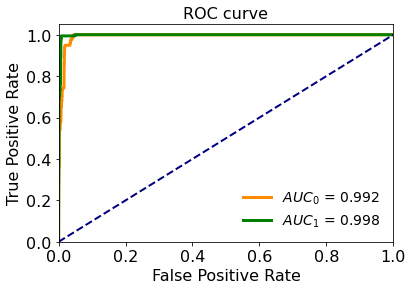

In [37]:
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [38]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 9881, 1: 9881})


Accuracy 0.9916137805983681
F1-score [0.99561767 0.90288714]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4236
           1       0.84      0.98      0.90       176

    accuracy                           0.99      4412
   macro avg       0.92      0.98      0.95      4412
weighted avg       0.99      0.99      0.99      4412



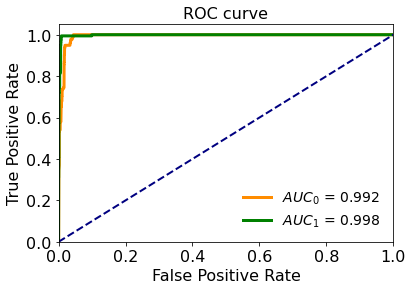

In [39]:
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### Class Weight

Accuracy 0.9782411604714415
F1-score [0.98868992 0.71428571]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4236
           1       0.75      0.68      0.71       176

    accuracy                           0.98      4412
   macro avg       0.87      0.84      0.85      4412
weighted avg       0.98      0.98      0.98      4412



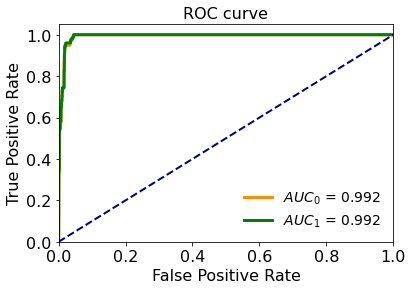

In [40]:
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=500, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0, 
                             class_weight={0:1, 1:2})
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# SVM

In [41]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

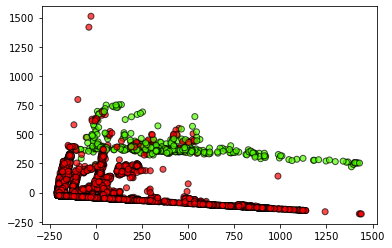

In [46]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Linear svm

In [55]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))


c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy 0.9601087941976428
F1-score [0.97964847 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       176

    accuracy                           0.96      4412
   macro avg       0.48      0.50      0.49      4412
weighted avg       0.92      0.96      0.94      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.96905814 0.99625978 0.98741925 0.99013941 0.97551853]


c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


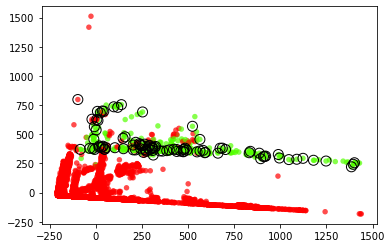

In [56]:
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()



### Undersampling: Random undersampling

Resampled dataset shape Counter({0: 412, 1: 412})
Accuracy 0.9891205802357208
F1-score [0.99430335 0.87939698]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4236
           1       0.79      0.99      0.88       176

    accuracy                           0.99      4412
   macro avg       0.89      0.99      0.94      4412
weighted avg       0.99      0.99      0.99      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


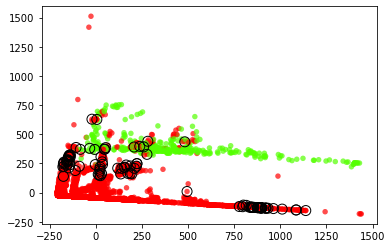

In [58]:
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Undersampling: Condensed Nearest Neighbour

Resampled dataset shape Counter({1: 412, 0: 74})
Accuracy 0.9601087941976428
F1-score [0.97964847 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       176

    accuracy                           0.96      4412
   macro avg       0.48      0.50      0.49      4412
weighted avg       0.92      0.96      0.94      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


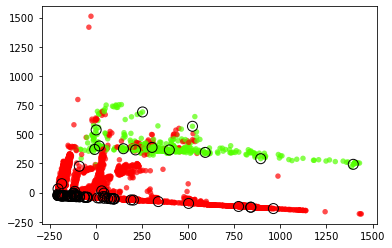

In [59]:
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Oversampling: Random over sampler

Resampled dataset shape Counter({0: 9881, 1: 9881})
Accuracy 0.9907071622846781
F1-score [0.99513815 0.89514066]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4236
           1       0.81      0.99      0.90       176

    accuracy                           0.99      4412
   macro avg       0.91      0.99      0.95      4412
weighted avg       0.99      0.99      0.99      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


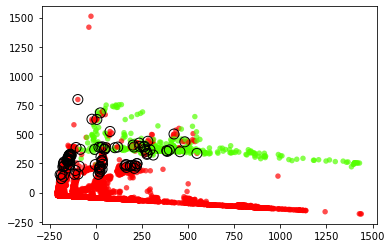

In [60]:
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Smote

Resampled dataset shape Counter({0: 9881, 1: 9881})
Accuracy 0.9904805077062556
F1-score [0.99501898 0.89285714]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4236
           1       0.81      0.99      0.89       176

    accuracy                           0.99      4412
   macro avg       0.90      0.99      0.94      4412
weighted avg       0.99      0.99      0.99      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


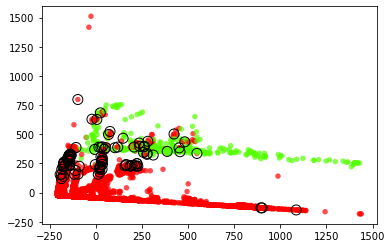

In [61]:
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Class Weight

c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy 0.9902538531278332
F1-score [0.99491184 0.8847185 ]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4236
           1       0.84      0.94      0.88       176

    accuracy                           0.99      4412
   macro avg       0.92      0.96      0.94      4412
weighted avg       0.99      0.99      0.99      4412



c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[0.97075825 0.9982999  0.98741925 0.99285957 0.87351241]


c:\users\gdm17\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


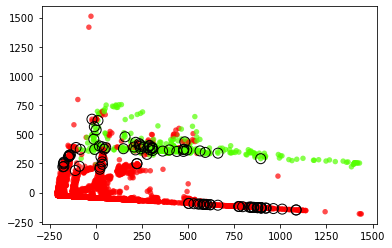

In [66]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1, random_state=42, class_weight={0:1, 1:3})
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]
support_vectors_pca = pca.transform(support_vectors)



plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()


## NonLinear svm

In [67]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9616953762466002
F1-score [0.98044208 0.07650273]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       1.00      0.04      0.08       176

    accuracy                           0.96      4412
   macro avg       0.98      0.52      0.53      4412
weighted avg       0.96      0.96      0.94      4412

[0.95987759 0.95987759 0.95987759 0.96021761 0.95953757]


### Random UnderSampler

In [71]:
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Resampled dataset shape Counter({0: 412, 1: 412})
Accuracy 0.5736627379873074
F1-score [0.71461083 0.15763547]
              precision    recall  f1-score   support

           0       1.00      0.56      0.71      4236
           1       0.09      1.00      0.16       176

    accuracy                           0.57      4412
   macro avg       0.54      0.78      0.44      4412
weighted avg       0.96      0.57      0.69      4412



### Random OverSampler

In [72]:
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Resampled dataset shape Counter({0: 9881, 1: 9881})
Accuracy 0.9637352674524026
F1-score [0.98146432 0.16666667]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       1.00      0.09      0.17       176

    accuracy                           0.96      4412
   macro avg       0.98      0.55      0.57      4412
weighted avg       0.97      0.96      0.95      4412



### SMOTE

In [73]:
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Resampled dataset shape Counter({0: 9881, 1: 9881})
Accuracy 0.9458295557570263
F1-score [0.97099867 0.59005146]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4236
           1       0.42      0.98      0.59       176

    accuracy                           0.95      4412
   macro avg       0.71      0.96      0.78      4412
weighted avg       0.98      0.95      0.96      4412



### Class Weight

In [75]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', class_weight={0:1, 1:3})
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9637352674524026
F1-score [0.98146432 0.16666667]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       1.00      0.09      0.17       176

    accuracy                           0.96      4412
   macro avg       0.98      0.55      0.57      4412
weighted avg       0.97      0.96      0.95      4412

[0.95987759 0.95987759 0.95987759 0.96021761 0.95919755]
